In [1]:
# // KEEP THIS AS IS!
# // docker pull tensorflow/build:2.20-python3.11
# // git clone https://github.com/tensorflow/tensorflow.git
# // Download NDK https://developer.android.com/ndk/downloads extract to "android-ndk-r27d"
# // Whe you downloaded the Android studio, the SDK shoyld be in your home dir
# // docker run -v ~/Android:/home/Android -v ./android-ndk-r27d:/home/android-ndk-r27d-linux -v ./tensorflow:/home/tensorflow -it  tensorflow/build:2.20-python3.11 /bin/sh
# //    cd /home/tensorflow
# //    ./configure # select "y" when asked to compile for Androdid and pass NDK path: `/home/android-ndk-r27d-linux` and Android SDK path `/home/Android/Sdk`
# //    bazel build -c opt --config=android_arm //tensorflow/lite/c:tensorflowlite_c
# //    cp bazel-bin/tensorflow/lite/libtensorflowlite.so .
# //    (outside docker) Get the libtensorflowlite.so and copy to ./app/src/jniLibs/arm64-v8a/libtensorflowlite_c.so
# //    bazel build -c opt --config=android_arm64 //tensorflow/lite/c:tensorflowlite_c
# //    cp bazel-bin/tensorflow/lite/c/libtensorflowlite_c.so .
# //    (outside docker) Get the libtensorflowlite_c.so and copy to ./app/src/jniLibs/armeabi-v7a/libtensorflowlite_c.so


In [2]:
# ! pip install --upgrade tensorflow

In [3]:
# ! pip3 install torch torchvision --index-url https://download.pytorch.org/whl/cu130

In [4]:
import numpy as np
import os
from matplotlib import pyplot as plt
from tqdm import tqdm
import pandas as pd
import seaborn as sn
import torch
from typing import List, Optional
import collections
from prettytable import PrettyTable
from scipy import signal
from fractions import Fraction
from sklearn.utils import class_weight

In [5]:

from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter




2025-11-11 08:30:10.412060: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-11 08:30:10.442277: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
DEVICE_USE = "cuda" # "cpu"/"cuda"

# Definitions

In [7]:
# Donde esta la data de los tonos del telefono
FILES = "../data/tektronic-2024" 

# Vamos a procesar solo una señal de tension, asi que vamos a tener solo un canal
SIGNAL_CHANNELS = 1
# Vamos a modificar la frecuencia de sampling, por si lo queremos exportar a otro lado
TARGET_FS = 44100
# Agregamos ruido
NOISE_MAX_ADD = 0.05
NOISE_MIN_ADD = 0.01

# Fraccion de muestras que vamos a usar para validar el entrenamiento (no se usan para entrenar)
valid_split = 0.10
# Cantidad de nuestras ve la red neuronal a cada vez, con esta cantidad de muestras va a decidir q tecla se presiono
sample_len = 512

# Nuestra red va a tener filtros de esta cantidad de elementos
kernels = [64,32,16]
# Y va a haber una cantidad de filtros de cada tamaño que elegimos dado por este numero de canales
channels = [32,64,128]



# Hiperparametros de entrenamiento:

# Cantidad de veces voy a pasar TODA la data de entrenamiento por la red
epochs = 100 
# Velocidad con la que actualizo los pesos de la red
lr = 1e-4
# Cantidad de muestras que tomo al mismo tiempo y uso para suavizar el calculo del gradiente
batch_size = 32
# Aca vamos a escribir los archivos de log
TENSORBOARD_FILE = "../untracked/outputs/conv-classifier"
# Aca se va a guardar
SAVE_PATH = "../untracked/outputs/conv-classifier-model"



# Dataset Generation

### Leemos la data

In [8]:

tones_dict = dict()
for folder in os.listdir(FILES):
    subfolder = os.path.join(FILES,folder)

    if 'TIEMPO' in subfolder:
        
        for file in os.listdir(subfolder):

            if '.CSV' in file:
                data=np.genfromtxt(os.path.join(subfolder,file),delimiter=',')
                name = subfolder.split("Medicion Tono ")[-1].split(" - TIEMPO")[0]
                raw_data = data[:,4]

                tiempo  = data[:,3]

                # Get sample rate
                sample_rate = (tiempo[1]-tiempo[0])
                f_muestreo = 1/sample_rate
                ratio = TARGET_FS/f_muestreo
                ratio_frac = Fraction(ratio).limit_denominator()
                # Resample to normalized frec and save tone
                # Si tenemos memoria es mas eficiente hacer upsample y downsample de numeros enteros.
                resampled_data = signal.resample_poly(raw_data, ratio_frac.numerator, ratio_frac.denominator)
                tones_dict[name] = resampled_data
                print(f"Found {len(resampled_data)} samples for target {name}")

Found 4410 samples for target 7
Found 4410 samples for target 8
Found 4410 samples for target ASTERISCO
Found 4410 samples for target 2
Found 4410 samples for target 4
Found 4410 samples for target NUMERAL
Found 4410 samples for target 6
Found 4410 samples for target 3
Found 4410 samples for target 9
Found 4410 samples for target 5
Found 2205 samples for target 1
Found 4410 samples for target 0


In [9]:
# sort the dictionary
tones_dict = collections.OrderedDict(sorted(tones_dict.items()))

In [10]:
print("la red va a ver %0.2f ms de señal"%(sample_len*(1/TARGET_FS)*1e3))

la red va a ver 11.61 ms de señal


In [11]:
# Calculo el maximo y minimo de las señales
max_min = [0,0]
for clase, key in enumerate(tones_dict.keys()):
    if max(tones_dict[key]) > max_min[0]:
        max_min[0] = max(tones_dict[key])
    if min(tones_dict[key]) > max_min[1]:
        max_min[1] = min(tones_dict[key])


### Creamos un dataset de pytorch

In [12]:
# Las clases a clasificar son la cantidad de teclas que grabamos
NUM_CLASES = len(list(tones_dict.keys()))

def add_noise(sample):
    noise_add = np.random.uniform(low=NOISE_MIN_ADD, high=NOISE_MAX_ADD,size=1)[0]
    sample += np.random.normal(loc=0.0, scale=noise_add, size=sample.shape[-1])
    sample = np.clip(sample,a_max=1.0, a_min=-1.0)
    # per-sample-normalization
    return sample/np.max(np.abs(sample))

train_samples_list = list()
train_targets_list = list()
validation_samples_list = list()
validation_targets_list = list()
check_div_train = list()
check_div_valid = list()
for num_draws in range(25):

    for clase, key in enumerate(tones_dict.keys()):
        # Normalizamos
        signal_use = tones_dict[key]

        # Dataset-wide normalization
        # signal_use = (signal_use-max_min[1])/(max_min[0]-max_min[1])
        

        # Cortamos y agregamos al dataset
        total_len = len(signal_use)

        total_samples = np.floor(total_len/sample_len).astype(int)
        valid_samples = np.round(total_samples*valid_split).astype(int)

        for sample_t in range(total_samples):

            # Select random start for draw
            start_rand = int((np.random.random(1)[0]-0.5)*100)
            this_start = (sample_t*sample_len)+start_rand
            this_end = ((sample_t+1)*sample_len)+start_rand
            if this_start < 0:
                continue
            if this_end >= total_len:
                continue

            # crop sample
            this_sample = np.expand_dims(signal_use[this_start:this_end], axis =0)
            

            this_sample_mirror = this_sample[::-1]
            this_sample_mirror_neg = -this_sample[::-1]
            this_sample_neg = -this_sample

            this_sample = add_noise(this_sample)
            this_sample_mirror = add_noise(this_sample_mirror)
            this_sample_mirror_neg = add_noise(this_sample_mirror_neg)
            this_sample_neg = add_noise(this_sample_neg)

            # one-hot target
            this_target = np.zeros((NUM_CLASES))
            this_target[clase] = 1
            # Assign
            if sample_t <= valid_samples:
                validation_samples_list.append(this_sample)
                validation_targets_list.append(this_target)
                check_div_valid.append(clase)

                validation_samples_list.append(this_sample_mirror)
                validation_targets_list.append(this_target)
                check_div_valid.append(clase)

                validation_samples_list.append(this_sample_mirror_neg)
                validation_targets_list.append(this_target)
                check_div_valid.append(clase)

                validation_samples_list.append(this_sample_neg)
                validation_targets_list.append(this_target)
                check_div_valid.append(clase)
            else:
                train_samples_list.append(this_sample)
                train_targets_list.append(this_target)
                check_div_train.append(clase)

                train_samples_list.append(this_sample_mirror)
                train_targets_list.append(this_target)
                check_div_train.append(clase)

                validation_samples_list.append(this_sample_mirror_neg)
                validation_targets_list.append(this_target)
                check_div_valid.append(clase)

                validation_samples_list.append(this_sample_neg)
                validation_targets_list.append(this_target)
                check_div_valid.append(clase)
                
train_samples = np.array(train_samples_list)
print(train_samples.shape)
train_targets = np.array(train_targets_list)
print(train_targets.shape)
validation_samples = np.array(validation_samples_list)
print(validation_samples.shape)
validation_targets = np.array(validation_targets_list)
print(validation_targets.shape)

tensor_x = torch.Tensor(train_samples) # transform to torch tensor
tensor_y = torch.Tensor(train_targets)
train_dataset = TensorDataset(tensor_x,tensor_y) # create your datset
tensor_x = torch.Tensor(validation_samples) # transform to torch tensor
tensor_y = torch.Tensor(validation_targets)
validation_dataset = TensorDataset(tensor_x,tensor_y) # create your datset




(3450, 1, 512)
(3450, 12)
(5162, 1, 512)
(5162, 12)


In [13]:
np.unique(check_div_valid, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 array([440, 206, 448, 452, 452, 456, 440, 448, 456, 480, 440, 444]))

In [14]:
np.unique(check_div_train, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 array([300, 150, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300]))

In [15]:
# Add class weights...
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(check_div_train),
    y=check_div_train
)
class_weights

array([0.95833333, 1.91666667, 0.95833333, 0.95833333, 0.95833333,
       0.95833333, 0.95833333, 0.95833333, 0.95833333, 0.95833333,
       0.95833333, 0.95833333])

In [16]:
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(DEVICE_USE)

# Neural Network Creation

Aca creamos la red neuronal, va a ser una red convolucional, la cual aprende formas de señal en cada uno de sus filtros (canales de los layers torch.nn.Conv1d)

In [17]:
class ConvClassifier(torch.nn.Module):
    def __init__(
        self,
        in_channels: int = 1,
        out_channels: int = 1,
        kernels: List[int] =  [],
        channels: List[int] =  [],
    ):
        super().__init__()

        self.conv_layers = list()

        assert len(kernels) == len(channels)

        # Aca proceamos la señal con una serie de filtros y vamos reduciendo el tamaño del vector de entrada
        self.conv1 = torch.nn.Conv1d(in_channels, channels[0], kernels[0],padding="same")
        self.act1 = torch.nn.ReLU()
        self.pool1 = torch.nn.MaxPool1d(kernel_size=2)
        self.conv2 = torch.nn.Conv1d(channels[0], channels[1], kernels[1],padding="same")
        self.act2 = torch.nn.ReLU()
        self.pool2 = torch.nn.MaxPool1d(kernel_size=2)
        self.conv3 = torch.nn.Conv1d(channels[1], channels[2], kernels[2],padding="same")
        self.act3 = torch.nn.ReLU()
        self.pool3 = torch.nn.MaxPool1d(kernel_size=2)

        # Esto solo transforma un tensor (matriz de mas de 2 dimenciones) en un vector
        self.flat = torch.nn.Flatten()

        # Este es el ultimo layer clasificador que aprende, mas que nada sirve para adaptar la salida de los layers anteriores a la cantidad de clases a clasificar.
        self.linear = torch.nn.Linear(channels[-1]*int(sample_len/(2**len(kernels))), out_channels)

        # Y esto convierte una salida de numeros arbitrarios en una distribucion de probabilidad (ponele)
        self.softmax = torch.nn.Softmax(dim=-1)

    def forward(self, x):
        # Esto es lo q se hace cuando se llama a la clase
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.act3(x)
        x = self.pool3(x)
        x = self.flat(x)
        x = self.linear(x)
        return self.softmax(x)


In [18]:
# Ahora instanciamos el modelo
model: torch.nn.Module = (
    ConvClassifier(
        in_channels=SIGNAL_CHANNELS,
        out_channels=NUM_CLASES,
        kernels = kernels,
        channels = channels
    )
    .to(DEVICE_USE)
)




In [19]:
# Checkeamos que ande con data random
x = torch.randn(8, 1, sample_len).to(DEVICE_USE)
y = model(x)
print(x.shape, y.shape)

torch.Size([8, 1, 512]) torch.Size([8, 12])


/home/rawthil/Documents/Medidas I - Catedra/Python Scope/pulsos-telefonicos/.venv/lib/python3.12/site-packages/torch/nn/modules/conv.py:366: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv1d(


In [20]:
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)

+---------------+------------+
|    Modules    | Parameters |
+---------------+------------+
|  conv1.weight |    2048    |
|   conv1.bias  |     32     |
|  conv2.weight |   65536    |
|   conv2.bias  |     64     |
|  conv3.weight |   131072   |
|   conv3.bias  |    128     |
| linear.weight |   98304    |
|  linear.bias  |     12     |
+---------------+------------+
Total Trainable Params: 297196


297196

# Training

In [21]:
# definimos la funcion ojetivo como la entropia cruzada
loss: torch.nn.Module = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)
# y al optimizador como ADAM
optimizer: torch.optim.Optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [22]:
# Creamos las clases "DataLoader" a partir de los datasets definidos anteriormente para que controlen los batches de entrenmiento y validacion. 
train_dataloader = DataLoader(train_dataset,
                                   batch_size=batch_size,
                                    shuffle=True,)


validation_dataloader = DataLoader(validation_dataset,
                                   batch_size=batch_size,
                                    shuffle=True,)


In [23]:
# Creamos una metrica para calcular el Accurracy, cuantas señales la red esta clasificando correctamente. 
# No se usa para entrenar, solo para que lo veamos nosotros.
class Accuracy:
    correct: int
    total: int

    def __init__(self) -> None:
        self.correct = 0
        self.total = 0

    def update(self, logits: torch.Tensor, labels: torch.Tensor) -> None:
        oh = torch.nn.functional.one_hot(logits.argmax(dim=-1), num_classes=labels.shape[-1]) 
        self.correct += int((oh*labels).sum())
        self.total += labels.shape[0]
        return None

    def compute(self) -> float:
        return self.correct / self.total

    def reset(self) -> None:
        self.correct = 0
        self.total = 0
        return None

In [24]:
# Declaramos todo lo que vamos a hacer en los pasos de entrenamiento y validacion

@torch.enable_grad()
def train_step(
    model: torch.nn.Module,
    train_data: DataLoader,
    loss: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    writer: SummaryWriter,
    epoch: int,
    device: torch.device,
    accuracy: Accuracy = Accuracy(),
) -> None:
    """
    This function train the model.

    Args:
        model: model to train.
        train_data: dataloader of train data.
        loss: loss function.
        optimizer: optimizer.
        writer: writer for tensorboard.
        epoch: epoch of the training.
        device: device for running operations.
    """
    # Training
    model.train()
    losses = []

    for inputs, targets in train_data:
        inputs, targets = inputs.to(device), targets.to(device)

        # forward
        outputs = model(inputs)

        # Compute loss
        loss_value = loss(outputs, targets)
        losses.append(loss_value.item())

        optimizer.zero_grad()
        loss_value.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        accuracy.update(outputs, targets)

    # Write to tensorboard
    writer.add_scalar("train/loss", np.mean(losses), epoch)
    writer.add_scalar("train/accuracy", accuracy.compute(), epoch)
    accuracy.reset()


@torch.no_grad()
def val_step(
    model: torch.nn.Module,
    val_data: DataLoader,
    loss: torch.nn.Module,
    scheduler: Optional[torch.optim.lr_scheduler.LRScheduler],
    writer: SummaryWriter,
    epoch: int,
    device: torch.device,
    accuracy: Accuracy = Accuracy(),
) -> None:
    """
    This function train the model.

    Args:
        model: model to train.
        val_data: dataloader of validation data.
        loss: loss function.
        scheduler: scheduler.
        writer: writer for tensorboard.
        epoch: epoch of the training.
        device: device for running operations.
    """
    # Validation
    model.eval()
    losses = []

    with torch.no_grad():
        for inputs, targets in val_data:
            inputs, targets = inputs.to(device), targets.to(device)

            # forward
            outputs = model(inputs)

            # Compute loss
            loss_value = loss(outputs, targets)
            losses.append(loss_value.item())

            # Update accuracy
            accuracy.update(outputs, targets)

    if scheduler is not None:
        scheduler.step()

    # Write to tensorboard
    # print(f"Validation loss: {np.mean(losses)}")
    writer.add_scalar("val/loss", np.mean(losses), epoch)
    writer.add_scalar("val/accuracy", accuracy.compute(), epoch)
    accuracy.reset()

In [25]:
# Creamos un "escritor", el cual usaremos para escribir los archivos de TensorBoard, una aplicacion que nos permite observar cosas durante el entrenamiento de la red.
writer = SummaryWriter(TENSORBOARD_FILE)
# Instanciamos la clase de accurracy
accuracy = Accuracy()
# define an empty scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=45, gamma=0.5)
# Train the model
for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times
    # call train step
    train_step(
        model, train_dataloader, loss, optimizer, writer, epoch, DEVICE_USE, accuracy
    )
    # call val step
    val_step(model, validation_dataloader, loss, scheduler, writer, epoch, DEVICE_USE, accuracy)
    # clear the GPU cache
    torch.cuda.empty_cache()

100%|██████████| 100/100 [00:20<00:00,  4.78it/s]


In [26]:
torch.save(model.state_dict(), SAVE_PATH)

# Reload Model, just because

In [27]:
MODEL_CHKP = SAVE_PATH #+ "-OK"
model.load_state_dict(torch.load(MODEL_CHKP, map_location=torch.device(DEVICE_USE)))

<All keys matched successfully>

# Validation Results

Aca miramos un poco que tan bien quedo el modelo

In [28]:
# Hacemos una pasada por todo el set de validacion, el cual no esta (tan) sesgado.
data_conf_mat = np.zeros((NUM_CLASES,NUM_CLASES))
for sample, target in validation_dataloader:
    # Invocamos la red
    y_hat = model(sample.to(DEVICE_USE))
    # Calculamos la clase predicha y la correcta    
    for correct, hat in zip(np.argmax(target.to("cpu").numpy(), axis=-1), np.argmax(y_hat.to("cpu").detach().numpy(), axis=-1)):
        # Completamos la matriz de confusion
        data_conf_mat[correct, hat] += 1


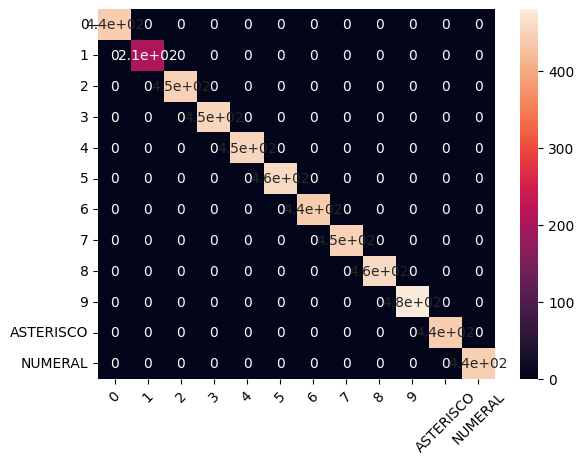

In [29]:
# Ploteamos la matriz de confusion que nos dice visualmente donde y como se equivoca la red al clasificar
# Una matriz diaganonal es un clasificador perfecto

df_cm = pd.DataFrame(data_conf_mat, index = [str(i) for i in tones_dict.keys()],
                  columns = [str(i) for i in tones_dict.keys()])
plt.figure(dpi = 100)
sn.heatmap(df_cm, annot=True)
ax = plt.gca()
ax.tick_params(axis='x', labelrotation=45)
ax.tick_params(axis='y', labelrotation=0)
plt.show()

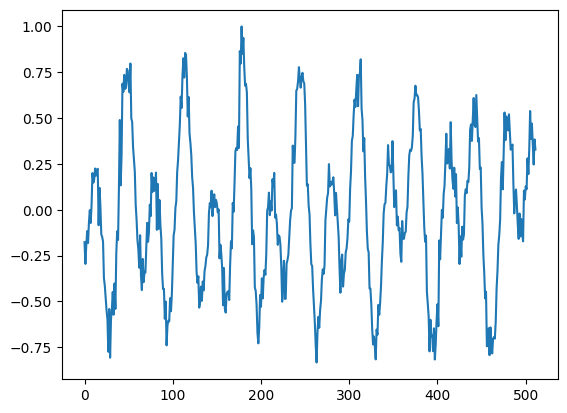

In [30]:
# Para que tengamos una idea, esto es todo lo que la red necesito ver:
plt.figure(dpi = 100)
plt.plot(sample[0][0,:])
plt.show()

In [31]:
sample[0]

tensor([[-1.7679e-01, -2.9511e-01, -1.9233e-01, -1.1672e-01, -1.8128e-01,
         -6.8350e-02, -2.0561e-03, -7.1883e-02,  2.7665e-02,  2.0043e-01,
          1.4807e-01,  1.6644e-01,  2.2523e-01,  1.8658e-01,  2.1805e-01,
          2.2392e-01, -8.4271e-02,  1.1975e-01,  2.0559e-02, -1.3427e-01,
         -1.4718e-01, -1.7437e-01, -3.7326e-01, -4.1442e-01, -4.8529e-01,
         -5.4962e-01, -5.9923e-01, -7.7477e-01, -5.4114e-01, -8.0671e-01,
         -5.9659e-01, -5.4290e-01, -4.4828e-01, -5.7227e-01, -4.0182e-01,
         -5.4067e-01, -2.3835e-01, -1.1735e-01, -1.6477e-01,  1.1851e-01,
          4.8987e-01,  1.3329e-01,  2.9853e-01,  6.8798e-01,  6.4332e-01,
          7.3586e-01,  6.5924e-01,  6.6630e-01,  7.6899e-01,  7.5883e-01,
          6.8678e-01,  6.4035e-01,  7.9793e-01,  4.9851e-01,  4.7946e-01,
          3.4338e-01,  2.7112e-01,  2.0674e-01,  2.6974e-02, -5.4227e-02,
         -1.6582e-01, -2.1505e-01, -3.1582e-01, -1.3861e-01, -3.6178e-01,
         -4.3795e-01, -2.6799e-01, -3.

In [37]:
# Checkeamos que ande con data random
x = [-1.7679e-01, -2.9511e-01, -1.9233e-01, -1.1672e-01, -1.8128e-01,
         -6.8350e-02, -2.0561e-03, -7.1883e-02,  2.7665e-02,  2.0043e-01,
          1.4807e-01,  1.6644e-01,  2.2523e-01,  1.8658e-01,  2.1805e-01,
          2.2392e-01, -8.4271e-02,  1.1975e-01,  2.0559e-02, -1.3427e-01,
         -1.4718e-01, -1.7437e-01, -3.7326e-01, -4.1442e-01, -4.8529e-01,
         -5.4962e-01, -5.9923e-01, -7.7477e-01, -5.4114e-01, -8.0671e-01,
         -5.9659e-01, -5.4290e-01, -4.4828e-01, -5.7227e-01, -4.0182e-01,
         -5.4067e-01, -2.3835e-01, -1.1735e-01, -1.6477e-01,  1.1851e-01,
          4.8987e-01,  1.3329e-01,  2.9853e-01,  6.8798e-01,  6.4332e-01,
          7.3586e-01,  6.5924e-01,  6.6630e-01,  7.6899e-01,  7.5883e-01,
          6.8678e-01,  6.4035e-01,  7.9793e-01,  4.9851e-01,  4.7946e-01,
          3.4338e-01,  2.7112e-01,  2.0674e-01,  2.6974e-02, -5.4227e-02,
         -1.6582e-01, -2.1505e-01, -3.1582e-01, -1.3861e-01, -3.6178e-01,
         -4.3795e-01, -2.6799e-01, -3.9461e-01, -3.3727e-01, -3.4208e-01,
         -1.9850e-01, -7.1203e-02, -1.7439e-01, -1.2060e-01,  2.7776e-02,
         -3.4559e-02,  2.0092e-01,  9.7429e-02,  1.7665e-01,  1.0334e-01,
          1.3014e-01,  2.0283e-01, -1.0944e-01,  1.4108e-01, -1.0429e-01,
          5.2875e-02, -8.2716e-02, -1.5735e-01, -3.4785e-01, -4.3226e-01,
         -4.3086e-01, -5.9464e-01, -5.0078e-01, -7.3953e-01, -6.3182e-01,
         -6.0535e-01, -6.0848e-01, -4.8251e-01, -5.5320e-01, -4.5841e-01,
         -3.0315e-01, -1.3898e-01, -1.0957e-01,  1.0145e-02,  4.5694e-02,
          2.0540e-01,  2.7015e-01,  3.7156e-01,  4.6268e-01,  6.1733e-01,
          5.5493e-01,  7.2800e-01,  8.2637e-01,  7.2166e-01,  8.5587e-01,
          8.4549e-01,  7.2947e-01,  5.0897e-01,  6.1559e-01,  4.1574e-01,
          3.6516e-01,  2.9857e-01,  1.7765e-01,  1.1931e-01, -1.3345e-02,
         -9.9303e-02, -1.8419e-01, -3.3810e-01, -3.9841e-01, -3.6261e-01,
         -5.3362e-01, -5.0396e-01, -4.1872e-01, -4.9613e-01, -3.9078e-01,
         -4.3923e-01, -3.3629e-01, -3.0700e-01, -2.5962e-01, -2.4516e-01,
         -1.9183e-01, -1.9465e-02,  3.6208e-02,  1.3398e-02,  1.0423e-01,
         -3.4287e-02,  2.9482e-02,  8.4678e-02,  1.4781e-02,  5.4274e-02,
          3.3666e-02, -1.4387e-02,  1.8693e-03, -2.6478e-01, -1.9056e-01,
         -2.4016e-01, -3.1859e-01, -5.2041e-01, -3.1752e-01, -5.3783e-01,
         -5.6058e-01, -4.5885e-01, -4.4701e-01, -4.4466e-01, -4.9230e-01,
         -3.0113e-01, -1.7093e-01, -2.0978e-01,  3.7729e-02, -1.0191e-02,
          1.4365e-01,  3.1923e-01,  3.3780e-01,  3.2588e-01,  4.5441e-01,
          3.3759e-01,  8.6555e-01,  7.9774e-01,  1.0000e+00,  8.5125e-01,
          9.3802e-01,  7.7958e-01,  6.7733e-01,  6.8746e-01,  6.3946e-01,
          3.8533e-01,  2.7295e-01,  1.7261e-01,  2.2722e-01,  1.1121e-01,
         -1.8765e-01, -1.1178e-01, -1.4944e-01, -4.2301e-01, -4.4203e-01,
         -5.1905e-01, -6.7252e-01, -7.2845e-01, -6.4047e-01, -4.6464e-01,
         -5.2905e-01, -3.7420e-01, -4.8319e-01, -3.7082e-01, -3.2843e-01,
         -3.5428e-01, -2.3710e-01, -6.1365e-03,  1.4840e-02,  9.3754e-02,
         -2.9221e-02,  4.5384e-02, -4.0069e-03,  1.6646e-01,  1.2818e-01,
          2.0115e-01, -4.2377e-02, -2.5480e-02, -7.4555e-02, -1.9111e-01,
         -1.3955e-01, -1.4623e-01, -1.9104e-01, -3.1286e-01, -5.0125e-01,
         -3.7083e-01, -2.7785e-01, -4.8612e-01, -4.8527e-01, -2.9331e-01,
         -2.7448e-01, -2.4452e-01, -1.5070e-01, -5.8240e-02, -5.1636e-03,
          8.8898e-03,  3.5011e-01,  2.5842e-01,  2.5631e-01,  3.9934e-01,
          6.4989e-01,  6.5925e-01,  7.0162e-01,  7.7803e-01,  7.1193e-01,
          6.6623e-01,  7.2293e-01,  7.4724e-01,  7.0089e-01,  6.9016e-01,
          5.7720e-01,  3.6290e-01,  1.3220e-01,  1.3983e-01,  2.2427e-02,
         -2.5282e-02, -1.8792e-01, -2.9663e-01, -3.0733e-01, -4.3040e-01,
         -5.2108e-01, -6.1537e-01, -7.3605e-01, -8.3286e-01, -6.7005e-01,
         -5.8408e-01, -6.4366e-01, -5.4658e-01, -4.9628e-01, -3.7860e-01,
         -3.2480e-01, -3.4899e-01, -3.0375e-01, -5.9377e-02,  6.0299e-03,
          6.6986e-02,  9.0627e-02,  2.4905e-01,  1.2715e-01,  1.5247e-01,
          1.3627e-01,  1.5354e-01,  1.7721e-01,  8.9006e-02, -3.0204e-02,
          9.2373e-02,  1.3423e-02, -6.9868e-02, -1.4805e-01, -3.1891e-01,
         -4.5204e-01, -2.7884e-01, -2.4431e-01, -4.1909e-01, -3.4764e-01,
         -3.2814e-01, -2.3280e-01, -2.1046e-01, -1.5490e-01, -5.2076e-02,
         -6.4748e-02,  1.1457e-01,  2.0952e-01,  3.7619e-01,  4.0279e-01,
          5.1734e-01,  6.0114e-01,  5.6161e-01,  6.5576e-01,  7.3605e-01,
          5.6504e-01,  7.3390e-01,  7.3891e-01,  8.2078e-01,  5.5241e-01,
          4.8963e-01,  3.1907e-01,  3.9126e-01,  1.7667e-01,  4.6367e-02,
         -1.1764e-01, -2.1238e-01, -2.3325e-01, -4.2844e-01, -4.3027e-01,
         -5.1449e-01, -6.4946e-01, -7.3440e-01, -6.9118e-01, -7.4668e-01,
         -8.1591e-01, -6.5353e-01, -6.8078e-01, -5.1857e-01, -5.7264e-01,
         -5.0832e-01, -4.1632e-01, -2.7954e-01, -1.7770e-01, -2.1112e-02,
          3.0048e-02,  3.7218e-02,  1.2912e-01,  1.9719e-01,  3.5297e-01,
          2.4673e-01,  2.4050e-01,  2.0401e-01,  2.1230e-01,  3.7440e-01,
          1.8424e-01,  1.4550e-02,  5.0225e-02,  1.0605e-01, -8.5091e-02,
         -3.7533e-02, -1.1148e-01, -9.9160e-02, -2.4008e-01, -2.8370e-01,
         -6.1275e-02, -1.5755e-01, -1.5846e-01, -1.2646e-01, -1.2028e-01,
         -1.4556e-02,  1.6542e-02,  1.8163e-01,  2.9642e-01,  3.2750e-01,
          3.2065e-01,  3.4091e-01,  4.0311e-01,  5.8667e-01,  6.0650e-01,
          6.7689e-01,  6.2485e-01,  6.2531e-01,  6.1361e-01,  5.3915e-01,
          4.3271e-01,  4.4111e-01,  2.9103e-01,  1.9831e-01,  5.2912e-02,
         -9.4087e-02, -1.7411e-01, -1.4077e-01, -4.4535e-01, -5.1318e-01,
         -5.8088e-01, -7.7228e-01, -5.9960e-01, -6.9334e-01, -6.8228e-01,
         -7.7100e-01, -6.4658e-01, -8.1664e-01, -7.3445e-01, -6.0124e-01,
         -5.1508e-01, -6.3535e-01, -1.6729e-01, -2.7062e-01, -1.2687e-01,
         -5.2158e-04, -4.3645e-02,  8.5196e-02,  1.3260e-01,  2.6495e-01,
          4.1502e-01,  2.5247e-01,  2.8470e-01,  3.3191e-01,  2.2494e-01,
          4.7805e-01,  2.6562e-01,  1.6361e-01,  1.1480e-01,  2.2978e-01,
          7.2880e-02,  1.9464e-01, -7.2367e-02,  1.2678e-02, -8.2654e-02,
         -2.9551e-01, -1.4497e-01, -2.5614e-01, -9.2249e-02, -1.6283e-01,
         -1.3484e-01,  7.7480e-02,  1.1205e-01,  9.0981e-02,  1.5828e-01,
          1.5083e-01,  2.2799e-01,  4.3634e-01,  4.6566e-01,  3.7565e-01,
          4.8607e-01,  6.0989e-01,  4.6365e-01,  4.5138e-01,  6.2629e-01,
          4.9341e-01,  3.7210e-01,  3.9112e-01,  2.2293e-01,  2.3094e-01,
          1.1868e-02, -7.5328e-02, -2.4527e-01, -3.4439e-01, -4.8335e-01,
         -4.4708e-01, -7.4449e-01, -6.9286e-01, -6.4609e-01, -7.9297e-01,
         -6.4104e-01, -7.2488e-01, -7.8348e-01, -7.0346e-01, -6.9441e-01,
         -7.0293e-01, -6.1244e-01, -4.2868e-01, -3.3453e-01, -1.9154e-01,
         -1.3873e-01, -5.4599e-02,  1.7613e-01,  2.6018e-01,  1.1149e-01,
          3.0631e-01,  5.3059e-01,  3.7954e-01,  5.0938e-01,  4.6236e-01,
          4.3299e-01,  5.2078e-01,  4.2237e-01,  3.2782e-01,  3.4002e-01,
          3.5591e-01,  1.4590e-01, -1.9456e-02,  7.6978e-02,  1.1049e-01,
          2.1242e-02, -7.9796e-02, -1.5860e-01, -2.0420e-02, -1.4547e-01,
         -5.0288e-02, -1.2701e-01, -1.7216e-01,  1.0469e-01,  5.6198e-02,
          1.2765e-01,  1.1212e-01,  2.8054e-01,  1.9472e-01,  3.3217e-01,
          5.3887e-01,  3.8725e-01,  4.7025e-01,  3.5477e-01,  2.4710e-01,
          3.8406e-01,  3.2884e-01]
x = (np.array(x) + np.random.normal(0.0, 0.05, len(x))).astype(np.float32)
x = torch.tensor(x)
x = torch.unsqueeze(x,0)
x = torch.unsqueeze(x,0).to("cpu")
y = model(x)
y

tensor([[0.0000e+00, 4.2179e-10, 1.0000e+00, 1.4618e-07, 2.0337e-21, 3.1695e-07,
         3.3957e-11, 1.4013e-45, 2.0135e-23, 1.1792e-22, 0.0000e+00, 6.8112e-40]],
       grad_fn=<SoftmaxBackward0>)

# Export to pt2

In [33]:
# Create example inputs for exporting the model. The inputs should be a tuple of tensors.
example_inputs = (torch.randn(1, 1, sample_len),)
exported_program = torch.export.export(model.to("cpu"), example_inputs)
torch.export.save(exported_program, SAVE_PATH+'.pt2')

# Export to ONNX

In [33]:
# ! pip install --upgrade onnx onnxscript
# ! pip install onnxruntime

In [34]:
# Create example inputs for exporting the model. The inputs should be a tuple of tensors.
example_inputs = (torch.randn(1, 1, sample_len),)
onnx_program = torch.onnx.export(model.to('cpu'), example_inputs, dynamo=True)
onnx_program.save(SAVE_PATH+".onnx")

[torch.onnx] Obtain model graph for `ConvClassifier([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `ConvClassifier([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 3 of general pattern rewrite rules.


In [35]:
import onnx

onnx_model = onnx.load(SAVE_PATH+".onnx")
onnx.checker.check_model(onnx_model)

# https://netron.app/

In [36]:
import onnxruntime

onnx_inputs = [tensor.numpy(force=True) for tensor in example_inputs]
print(f"Input length: {len(onnx_inputs)}")
print(f"Sample input: {onnx_inputs}")

ort_session = onnxruntime.InferenceSession(
    SAVE_PATH+".onnx", providers=["CPUExecutionProvider"]
)

onnxruntime_input = {input_arg.name: input_value for input_arg, input_value in zip(ort_session.get_inputs(), onnx_inputs)}

# ONNX Runtime returns a list of outputs
onnxruntime_outputs = ort_session.run(None, onnxruntime_input)[0]

Input length: 1
Sample input: [array([[[-0.85752857,  0.88903725,  0.41039523,  0.4041067 ,
          0.67866004, -0.5789586 ,  0.9021367 , -0.8322785 ,
          1.446906  ,  0.07000285,  1.6057711 , -0.52336603,
         -1.4589152 , -0.5445612 , -1.12028   , -0.9826289 ,
          0.5966443 , -1.6271447 ,  0.8106954 ,  1.1301545 ,
          0.6104642 , -1.0830524 ,  0.72073454, -0.9228019 ,
         -0.6446572 , -0.87059313,  0.42162746,  0.11454222,
         -0.6585812 , -0.38979802, -0.36342564,  0.9597938 ,
          1.1277684 , -0.49148396, -0.16278496,  1.4077227 ,
          0.76364654, -0.3936701 , -0.6631883 , -0.60190463,
         -0.7140678 , -1.2511106 , -0.78088176, -0.95469874,
          0.53647274,  0.05585825,  0.8956026 ,  0.5014642 ,
          0.6229181 ,  1.7327665 , -0.24871334,  2.4631815 ,
         -0.3251221 ,  0.10004984, -1.022844  ,  0.24974988,
         -2.2172246 ,  0.43031114, -0.6388311 ,  0.36677578,
         -1.0740646 ,  2.3721094 , -0.97979647, -1.863

In [31]:
torch_outputs = model.to("cpu")(*example_inputs)

assert len(torch_outputs) == len(onnxruntime_outputs)
for torch_output, onnxruntime_output in zip(torch_outputs, onnxruntime_outputs):
    torch.testing.assert_close(torch_output, torch.tensor(onnxruntime_output))

print("PyTorch and ONNX Runtime output matched!")
print(f"Output length: {len(onnxruntime_outputs)}")
print(f"Sample output: {onnxruntime_outputs}")

PyTorch and ONNX Runtime output matched!
Output length: 1
Sample output: [[0.0000000e+00 1.0000000e+00 3.4866434e-15 0.0000000e+00 2.9941141e-09
  4.1594126e-36 0.0000000e+00 3.0351468e-23 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00]]


# Quantization Aware Training

In [ ]:
raise ValueError("para aca abajo not tested")

In [ ]:
! pip install torchao/

ERROR: Invalid requirement: 'torchao/': Expected end or semicolon (after name and no valid version specifier)
    torchao/
           ^
Hint: It looks like a path. File 'torchao/' does not exist.


In [ ]:


import torch
import torch.nn as nn
from torchao.quantization.prototype.qat import Int8DynActInt4WeightQATQuantizer


import copy



In [ ]:
# Quantization parameters
groupsize = 32
padding_allowed = False


In [ ]:
def prepare_for_qat(model):
    print("Preparing model for Quantization-Aware Training")
    
    # Clone the model for quantization
    model_quant = copy.deepcopy(model)
    
    # Cut the model size in half by removing middle layers
    if hasattr(model_quant, "model") and hasattr(model_quant.model, "layers"):
        # For Qwen2 model structure with model.layers
        num_layers = len(model_quant.model.layers)
        keep_layers = num_layers // 2
        
        # Keep first half of the layers
        model_quant.model.layers = model_quant.model.layers[:keep_layers]
        
        print(f"Reduced model from {num_layers} to {keep_layers} layers")
    
    # Create quantizer
    qat_quantizer = Int8DynActInt4WeightQATQuantizer(
        groupsize=groupsize,
        padding_allowed=padding_allowed
    )
    
    # Prepare the model for QAT
    print("Running prepare() to set up QAT layers")
    model_quant = qat_quantizer.prepare(model_quant)
    
    # Rest of your function...
    return model_quant, qat_quantizer


In [ ]:
model_quant, qat_quantizer = prepare_for_qat(model)

Preparing model for Quantization-Aware Training
Running prepare() to set up QAT layers


In [ ]:
model_quant.train()




ConvClassifier(
  (conv1): Conv1d(1, 16, kernel_size=(32,), stride=(1,), padding=same)
  (act1): ReLU()
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(16, 32, kernel_size=(16,), stride=(1,), padding=same)
  (act2): ReLU()
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(8,), stride=(1,), padding=same)
  (act3): ReLU()
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (linear): Int8DynActInt4WeightQATLinear(
    in_features=512, out_features=12, bias=True
    (activation_fake_quantizer): FakeQuantizer(IntxFakeQuantizeConfig(dtype=torch.int8, granularity=PerToken(), mapping_type=<MappingType.ASYMMETRIC: 3>, scale_precision=torch.float32, zero_point_precision=torch.float32, zero_point_domain=<ZeroPointDomain.INT: 1>, is_dynamic=True, range_learning=False, eps=1.1920928955078125e

In [ ]:
writer = SummaryWriter(TENSORBOARD_FILE+"_quant")
# Instanciamos la clase de accurracy
accuracy = Accuracy()
# define an empty scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=45, gamma=0.5)
# Train the model
for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times
    # call train step
    train_step(
        model_quant, train_dataloader, loss, optimizer, writer, epoch, DEVICE_USE, accuracy
    )
    # call val step
    val_step(model_quant, validation_dataloader, loss, scheduler, writer, epoch, DEVICE_USE, accuracy)
    # clear the GPU cache
    torch.cuda.empty_cache()

100%|██████████| 50/50 [00:22<00:00,  2.18it/s]


In [ ]:
torch.save(model_quant.state_dict(), SAVE_PATH+"_quant")

In [ ]:
def finalize_quantization(model_quant, qat_quantizer, output_dir):
    print("=============================================", flush=True)
    print("STARTING QUANTIZATION FINALIZATION PROCESS", flush=True)
    print("=============================================", flush=True)
    
    try:
        # Log the models we're working with
        print(f"Model_quant type: {type(model_quant)}", flush=True)
        print(f"QAT Quantizer type: {type(qat_quantizer)}", flush=True)
        
        # Convert to actual quantized operations
        print("ATTEMPTING to convert QAT model to int4...", flush=True)
        model_int4 = qat_quantizer.convert(model_quant)
        print(f"CONVERSION SUCCESSFUL - model_int4 type: {type(model_int4)}", flush=True)
        
        # Create output directories
        int4_output_dir = os.path.join(output_dir, "int4_model")
        print(f"Creating directory: {int4_output_dir}", flush=True)
        os.makedirs(int4_output_dir, exist_ok=True)
        print(f"Directory created successfully: {os.path.exists(int4_output_dir)}", flush=True)
        
        fp32_output_dir = os.path.join(output_dir, "fp32_model")
        print(f"Creating directory: {fp32_output_dir}", flush=True)
        os.makedirs(fp32_output_dir, exist_ok=True)
        print(f"Directory created successfully: {os.path.exists(fp32_output_dir)}", flush=True)
        
        # Save the state dicts with .pt extension
        int4_model_path = os.path.join(int4_output_dir, "model.pt")
        print(f"ATTEMPTING to save int4 quantized model to: {int4_model_path}", flush=True)
        
        # Inspect state dict before saving
        int4_state_dict = model_int4.state_dict()
        print(f"Int4 state dict contains {len(int4_state_dict)} keys", flush=True)
        print(f"First few keys: {list(int4_state_dict.keys())[:3]}", flush=True)
        
        # Save INT4 model
        torch.save(int4_state_dict, int4_model_path)
        print(f"Int4 model SAVED successfully: {os.path.exists(int4_model_path)}", flush=True)
        
        # Save FP32 model
        fp32_model_path = os.path.join(fp32_output_dir, "model.pt")
        print(f"ATTEMPTING to save fp32 model to: {fp32_model_path}", flush=True)
        
        # Inspect original model state dict
        fp32_state_dict = model.state_dict()
        print(f"FP32 state dict contains {len(fp32_state_dict)} keys", flush=True)
        print(f"First few keys: {list(fp32_state_dict.keys())[:3]}", flush=True)
        
        # Save FP32 modelmodel_quant
        torch.save(fp32_state_dict, fp32_model_path)
        print(f"FP32 model SAVED successfully: {os.path.exists(fp32_model_path)}", flush=True)
        
        # Verify files exist and compare sizes
        print("CHECKING file sizes...", flush=True)
        if os.path.exists(int4_model_path) and os.path.exists(fp32_model_path):
            # Get file sizes
            fp32_size = os.path.getsize(fp32_model_path) / (1024 ** 2)
            int4_size = os.path.getsize(int4_model_path) / (1024 ** 2)
            
            # Log size comparison
            print(f"FILE SIZE COMPARISON:", flush=True)
            print(f"FP32 Model size: {fp32_size:.2f} MB", flush=True)
            print(f"INT4 Model size: {int4_size:.2f} MB", flush=True)
            
            if fp32_size > 0:  # Avoid division by zero
                reduction = (1 - int4_size/fp32_size) * 100
                print(f"Size reduction: {reduction:.2f}%", flush=True)
            else:
                print("FP32 model size is 0, cannot calculate reduction percentage", flush=True)
        else:
            if not os.path.exists(int4_model_path):
                print(f"INT4 MODEL FILE NOT FOUND at {int4_model_path}", flush=True)
            if not os.path.exists(fp32_model_path):
                print(f"FP32 MODEL FILE NOT FOUND at {fp32_model_path}", flush=True)
            print("Could not compare model sizes; one or both files not found", flush=True)
        
        print("QUANTIZATION FINALIZATION COMPLETED SUCCESSFULLY", flush=True)
        return model_int4
        
    except Exception as e:
        print("!!!! EXCEPTION DURING QUANTIZATION FINALIZATION !!!!", flush=True)
        print(f"Error message: {str(e)}", flush=True)
        print(f"Error type: {type(e).__name__}", flush=True)
        
        # Check what stage we were at when the error occurred
        if 'model_int4' not in locals():
            print("Error occurred during model conversion", flush=True)
        elif not os.path.exists(int4_output_dir):
            print("Error occurred creating output directories", flush=True)
        elif not os.path.exists(int4_model_path):
            print("Error occurred saving int4 model", flush=True)
        elif not os.path.exists(fp32_model_path):
            print("Error occurred saving fp32 model", flush=True)
        
        # Print full traceback
        import traceback
        print("Full traceback:", flush=True)
        traceback.print_exc()
        
        print("QUANTIZATION FINALIZATION FAILED", flush=True)
        return None


In [ ]:
# Convert the QAT model to int4
model_int4 = finalize_quantization(model_quant, qat_quantizer, '../untracked/outputs/conv-classifier_quant-models')



STARTING QUANTIZATION FINALIZATION PROCESS
Model_quant type: <class '__main__.ConvClassifier'>
QAT Quantizer type: <class 'torchao.quantization.qat.linear.Int8DynActInt4WeightQATQuantizer'>
ATTEMPTING to convert QAT model to int4...
CONVERSION SUCCESSFUL - model_int4 type: <class '__main__.ConvClassifier'>
Creating directory: ../untracked/outputs/conv-classifier_quant-models/int4_model
Directory created successfully: True
Creating directory: ../untracked/outputs/conv-classifier_quant-models/fp32_model
Directory created successfully: True
ATTEMPTING to save int4 quantized model to: ../untracked/outputs/conv-classifier_quant-models/int4_model/model.pt
Int4 state dict contains 10 keys
First few keys: ['conv1.weight', 'conv1.bias', 'conv2.weight']
Int4 model SAVED successfully: True
ATTEMPTING to save fp32 model to: ../untracked/outputs/conv-classifier_quant-models/fp32_model/model.pt
FP32 state dict contains 8 keys
First few keys: ['conv1.weight', 'conv1.bias', 'conv2.weight']
FP32 model 

In [ ]:
# Create example inputs for exporting the model. The inputs should be a tuple of tensors.
example_inputs = (torch.randn(1, 1, sample_len),)
onnx_program = torch.onnx.export(model_int4.to('cpu'), example_inputs, dynamo=True)
onnx_program.save(SAVE_PATH+"_quant.onnx")

[torch.onnx] Obtain model graph for `ConvClassifier([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `ConvClassifier([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 6 of general pattern rewrite rules.


In [ ]:
torch_outputs = model_int4.to("cpu")(*example_inputs)

assert len(torch_outputs) == len(onnxruntime_outputs)
for torch_output, onnxruntime_output in zip(torch_outputs, onnxruntime_outputs):
    torch.testing.assert_close(torch_output, torch.tensor(onnxruntime_output))

print("PyTorch and ONNX Runtime output matched!")
print(f"Output length: {len(onnxruntime_outputs)}")
print(f"Sample output: {onnxruntime_outputs}")

Input length: 1
Sample input: [array([[[-0.03954845,  0.9835531 , -0.7601987 ,  1.2180696 ,
         -0.30198207,  0.742465  ,  0.48246643,  0.50821084,
          1.0828743 ,  1.4652333 ,  0.37045375,  1.4433993 ,
         -0.06499626, -1.3561546 ,  0.32569176, -0.24471399,
          1.3512563 , -1.2679436 ,  0.54528797, -1.9313889 ,
          0.19849275,  1.6965966 ,  1.9553428 ,  2.404765  ,
          2.036776  , -1.5104887 , -1.1321222 ,  0.9680639 ,
         -0.769951  , -1.5261551 ,  0.210175  ,  1.7739929 ,
          1.0361305 ,  0.5135848 ,  0.83530587,  0.1666315 ,
         -0.20901081,  0.8739953 , -1.1907662 ,  0.00768849,
          0.5768476 ,  1.295432  ,  0.86433834,  1.1940644 ,
         -0.41080448,  0.43456796, -0.31526923, -0.28453413,
         -0.7002098 , -1.0483224 , -0.16981965,  1.5713694 ,
          1.0245306 ,  2.6205738 ,  0.13202128, -0.146936  ,
          0.9475067 ,  0.72549003,  1.0988694 , -0.5206204 ,
         -0.97657514,  1.2747043 ,  0.97218925, -1.381

In [ ]:
print("Dtypes of model parameters:")
for name, param in model_int4.named_parameters():
    print(f"Parameter '{name}': dtype={param.dtype}")

Dtypes of model parameters:
Parameter 'conv1.weight': dtype=torch.float32
Parameter 'conv1.bias': dtype=torch.float32
Parameter 'conv2.weight': dtype=torch.float32
Parameter 'conv2.bias': dtype=torch.float32
Parameter 'conv3.weight': dtype=torch.float32
Parameter 'conv3.bias': dtype=torch.float32
Parameter 'linear.bias': dtype=torch.float32
